# Collaboration and Competition

---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='../apps/Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import copy
from collections import deque, namedtuple

In [5]:
# Helper Functions
def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]

def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

def stack_tensor(some_list):
    return torch.cat(some_list[:1000], dim=0)

In [6]:
# Models
class SubNetwork(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, seed):
        super(SubNetwork, self).__init__()
        dims = (input_size,) + hidden_units        
        self.layers = nn.ModuleList([layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.feature_dim = dims[-1]
        self.output_layer = layer_init(nn.Linear(self.feature_dim, output_size), 1e-3)
        
    def forward(self, x):
        for layer in self.layers:
            x = F.tanh(layer(x))
        x = self.output_layer(x)    
        return x    
    
class ActorAndCritic(nn.Module):
    def __init__(self, seed):
        super(ActorAndCritic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.sd = nn.Parameter(torch.zeros(2))
        self.actor = SubNetwork(24, (400, 300), 2, 5)
        self.critic = SubNetwork(24, (400, 300), 1, 5)
        
    def forward(self, states):
        x = self.actor(states)
        mean = F.tanh(x)
        values = self.critic(states)
        dist = torch.distributions.Normal(mean, F.softplus(self.sd))
        actions = torch.clamp(dist.sample(), -1, 1)
        return actions, values, dist.log_prob(actions).mean(1).unsqueeze(1), dist

In [9]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.network = ActorAndCritic(5)
        self.optimizer = optim.Adam(self.network.parameters(), lr = 5e-5)
    
    def act(self, states):
        with torch.no_grad():
            actions, values, log_probs, dist = self.network(states)
        return actions, values, log_probs, dist
    
    def step(self, old_log_probs, states, actions, rewards, dones, values, mean_score):
        rewards = torch.tensor(rewards, dtype = torch.float).unsqueeze(2)
        dones = torch.tensor(dones, dtype = torch.int).unsqueeze(2)
        
        advantages = [0.0] * 250
        returns = [0.0] * 250
        advantage = torch.zeros((2, 1))
        return_ = torch.zeros((2, 1))
        for i in reversed(range(250)):
            if i == 250 - 1:
                td = rewards[i] - values[i]
            else:
                td = rewards[i] + (0.99 * (1-dones[i]) * values[i + 1]) - values[i]
            advantage = advantage * 0.95 * 0.99 * (1-dones[i]) + td
            return_ = rewards[i] + 0.99 * (1-dones[i]) * return_           
            advantages[i] = advantage
            returns[i] = return_
            
        old_log_probs, states, actions, values, advantages, returns = \
        stack_tensor(old_log_probs), stack_tensor(states),stack_tensor(actions),\
        stack_tensor(values), stack_tensor(advantages), stack_tensor(returns)
        advantages = torch.clamp((advantages - advantages.mean()) / advantages.std(), -1e5, 1e5)
        
        if mean_score>=0.80:
            epoch = 1
        elif mean_score>=0.40:
            epoch = 3
        elif mean_score>=0.20:
            epoch = 5
        else:
            epoch = 10
        for e in range(epoch):
            samples = random_sample(np.arange(250 * 2), 100)
            for sample in samples:
                states_1 = states[sample]
                actions_1 = actions[sample]
                old_log_probs_1 = old_log_probs[sample]
                advantages_1 = advantages[sample]
                returns_1 = returns[sample]
                
                _, values_1, _, dist = self.network(states_1)
                new_log_probs_1 = dist.log_prob(actions_1).mean(1).unsqueeze(1)

                new_probs, old_probs = torch.exp(new_log_probs_1), torch.exp(old_log_probs_1)
                ratios = new_probs / old_probs
                ratios_clipped = torch.clamp(ratios, 0.9, 1.1)
                entropy = -(new_probs * torch.log(old_probs + 1e-10) + (1.0 - new_probs) * torch.log(1.0 - old_probs + 1e-10))

                rewards_clipped = -torch.min(ratios * advantages_1, ratios_clipped * advantages_1)
                rewards_clipped = torch.mean(rewards_clipped + 0.01 * entropy)
                loss = 0.5 * torch.mean((returns_1 - values_1)**2)
                total_loss = rewards_clipped + loss
                
                self.optimizer.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), 10) 
                self.optimizer.step()

agent = Agent()

In [10]:
scores = []
scores_window = deque(maxlen=100)
scores_window_3 = deque(maxlen=3)
log_probs_all, states_all, actions_all, rewards_all, dones_all, values_all = [], [], [], [], [], []
sample_num = 0
for i in range(15000):                                         
    env_info = env.reset(train_mode=True)[brain_name]     
    states = torch.tensor(env_info.vector_observations, dtype = torch.float)
    score = np.zeros(num_agents) 
    count = 0
    while True:
        actions, values, log_probs, _ = agent.act(states)
        env_info = env.step(actions.detach().numpy())[brain_name]           
        next_states = torch.tensor(env_info.vector_observations, dtype = torch.float)
        dones = env_info.local_done
        
        log_probs_all.append(log_probs)
        states_all.append(states)
        actions_all.append(actions)
        rewards_all.append(env_info.rewards)
        dones_all.append(dones)
        values_all.append(values)
        score += env_info.rewards
        states = next_states 
        
        if sample_num == 249 and np.mean(scores_window_3)<1.5:
            agent.step(log_probs_all, states_all, actions_all, rewards_all, dones_all, values_all, np.mean(scores_window))
            log_probs_all, states_all, actions_all, rewards_all, dones_all, values_all = [], [], [], [], [], []
        
        count += 1
        sample_num = (sample_num + 1) % 250
        if np.any(dones):                                  
            break
               
    scores.append(np.max(score))
    scores_window.append(np.max(score))
    scores_window_3.append(np.max(score))
    print('\rEpisode {}\tReward: {:.5f}\tAverage Reward: {:.5f}'.format(i, np.max(score), np.mean(scores_window)))
    if np.mean(scores_window) >= 1.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, np.mean(scores_window)))
        torch.save(agent.network.state_dict(), 'checkpoint/trained_weights_ppo.pth')
        break

Episode 0	Reward: 0.10000	Average Reward: 0.10000
Episode 1	Reward: 0.00000	Average Reward: 0.05000
Episode 2	Reward: 0.00000	Average Reward: 0.03333
Episode 3	Reward: 0.00000	Average Reward: 0.02500
Episode 4	Reward: 0.10000	Average Reward: 0.04000
Episode 5	Reward: 0.00000	Average Reward: 0.03333
Episode 6	Reward: 0.00000	Average Reward: 0.02857
Episode 7	Reward: 0.00000	Average Reward: 0.02500
Episode 8	Reward: 0.00000	Average Reward: 0.02222
Episode 9	Reward: 0.00000	Average Reward: 0.02000
Episode 10	Reward: 0.00000	Average Reward: 0.01818
Episode 11	Reward: 0.00000	Average Reward: 0.01667
Episode 12	Reward: 0.00000	Average Reward: 0.01538
Episode 13	Reward: 0.00000	Average Reward: 0.01429
Episode 14	Reward: 0.00000	Average Reward: 0.01333
Episode 15	Reward: 0.00000	Average Reward: 0.01250
Episode 16	Reward: 0.00000	Average Reward: 0.01176
Episode 17	Reward: 0.00000	Average Reward: 0.01111
Episode 18	Reward: 0.00000	Average Reward: 0.01053
Episode 19	Reward: 0.00000	Average Reward

Episode 162	Reward: 0.09000	Average Reward: 0.02590
Episode 163	Reward: 0.00000	Average Reward: 0.02490
Episode 164	Reward: 0.00000	Average Reward: 0.02490
Episode 165	Reward: 0.00000	Average Reward: 0.02390
Episode 166	Reward: 0.10000	Average Reward: 0.02490
Episode 167	Reward: 0.00000	Average Reward: 0.02490
Episode 168	Reward: 0.00000	Average Reward: 0.02390
Episode 169	Reward: 0.00000	Average Reward: 0.02300
Episode 170	Reward: 0.00000	Average Reward: 0.02300
Episode 171	Reward: 0.10000	Average Reward: 0.02400
Episode 172	Reward: 0.10000	Average Reward: 0.02500
Episode 173	Reward: 0.00000	Average Reward: 0.02500
Episode 174	Reward: 0.00000	Average Reward: 0.02500
Episode 175	Reward: 0.10000	Average Reward: 0.02600
Episode 176	Reward: 0.00000	Average Reward: 0.02600
Episode 177	Reward: 0.00000	Average Reward: 0.02600
Episode 178	Reward: 0.00000	Average Reward: 0.02510
Episode 179	Reward: 0.00000	Average Reward: 0.02510
Episode 180	Reward: 0.00000	Average Reward: 0.02510
Episode 181	

Episode 321	Reward: 0.10000	Average Reward: 0.03310
Episode 322	Reward: 0.00000	Average Reward: 0.03310
Episode 323	Reward: 0.00000	Average Reward: 0.03310
Episode 324	Reward: 0.00000	Average Reward: 0.03210
Episode 325	Reward: 0.00000	Average Reward: 0.03210
Episode 326	Reward: 0.00000	Average Reward: 0.03110
Episode 327	Reward: 0.00000	Average Reward: 0.03110
Episode 328	Reward: 0.10000	Average Reward: 0.03210
Episode 329	Reward: 0.00000	Average Reward: 0.03210
Episode 330	Reward: 0.10000	Average Reward: 0.03310
Episode 331	Reward: 0.00000	Average Reward: 0.03220
Episode 332	Reward: 0.00000	Average Reward: 0.03220
Episode 333	Reward: 0.00000	Average Reward: 0.03120
Episode 334	Reward: 0.10000	Average Reward: 0.03220
Episode 335	Reward: 0.00000	Average Reward: 0.03220
Episode 336	Reward: 0.00000	Average Reward: 0.03120
Episode 337	Reward: 0.10000	Average Reward: 0.03220
Episode 338	Reward: 0.00000	Average Reward: 0.03120
Episode 339	Reward: 0.00000	Average Reward: 0.03120
Episode 340	

Episode 479	Reward: 0.00000	Average Reward: 0.02930
Episode 480	Reward: 0.10000	Average Reward: 0.03030
Episode 481	Reward: 0.00000	Average Reward: 0.03030
Episode 482	Reward: 0.10000	Average Reward: 0.03130
Episode 483	Reward: 0.00000	Average Reward: 0.03040
Episode 484	Reward: 0.10000	Average Reward: 0.03140
Episode 485	Reward: 0.10000	Average Reward: 0.03240
Episode 486	Reward: 0.00000	Average Reward: 0.03240
Episode 487	Reward: 0.10000	Average Reward: 0.03340
Episode 488	Reward: 0.00000	Average Reward: 0.03340
Episode 489	Reward: 0.00000	Average Reward: 0.03240
Episode 490	Reward: 0.09000	Average Reward: 0.03330
Episode 491	Reward: 0.00000	Average Reward: 0.03330
Episode 492	Reward: 0.20000	Average Reward: 0.03430
Episode 493	Reward: 0.09000	Average Reward: 0.03420
Episode 494	Reward: 0.00000	Average Reward: 0.03420
Episode 495	Reward: 0.10000	Average Reward: 0.03520
Episode 496	Reward: 0.10000	Average Reward: 0.03620
Episode 497	Reward: 0.19000	Average Reward: 0.03810
Episode 498	

Episode 640	Reward: 0.00000	Average Reward: 0.05450
Episode 641	Reward: 0.00000	Average Reward: 0.05350
Episode 642	Reward: 0.09000	Average Reward: 0.05340
Episode 643	Reward: 0.00000	Average Reward: 0.05240
Episode 644	Reward: 0.00000	Average Reward: 0.05140
Episode 645	Reward: 0.10000	Average Reward: 0.05240
Episode 646	Reward: 0.00000	Average Reward: 0.05140
Episode 647	Reward: 0.10000	Average Reward: 0.05140
Episode 648	Reward: 0.09000	Average Reward: 0.05230
Episode 649	Reward: 0.00000	Average Reward: 0.05230
Episode 650	Reward: 0.00000	Average Reward: 0.05130
Episode 651	Reward: 0.00000	Average Reward: 0.05130
Episode 652	Reward: 0.00000	Average Reward: 0.05030
Episode 653	Reward: 0.20000	Average Reward: 0.05230
Episode 654	Reward: 0.10000	Average Reward: 0.05130
Episode 655	Reward: 0.10000	Average Reward: 0.05230
Episode 656	Reward: 0.00000	Average Reward: 0.05130
Episode 657	Reward: 0.00000	Average Reward: 0.05130
Episode 658	Reward: 0.10000	Average Reward: 0.05230
Episode 659	

Episode 800	Reward: 0.09000	Average Reward: 0.05600
Episode 801	Reward: 0.00000	Average Reward: 0.05500
Episode 802	Reward: 0.10000	Average Reward: 0.05600
Episode 803	Reward: 0.20000	Average Reward: 0.05700
Episode 804	Reward: 0.00000	Average Reward: 0.05700
Episode 805	Reward: 0.00000	Average Reward: 0.05700
Episode 806	Reward: 0.00000	Average Reward: 0.05700
Episode 807	Reward: 0.09000	Average Reward: 0.05690
Episode 808	Reward: 0.00000	Average Reward: 0.05390
Episode 809	Reward: 0.00000	Average Reward: 0.05390
Episode 810	Reward: 0.00000	Average Reward: 0.05290
Episode 811	Reward: 0.00000	Average Reward: 0.05190
Episode 812	Reward: 0.10000	Average Reward: 0.05290
Episode 813	Reward: 0.00000	Average Reward: 0.05190
Episode 814	Reward: 0.20000	Average Reward: 0.05290
Episode 815	Reward: 0.10000	Average Reward: 0.05390
Episode 816	Reward: 0.09000	Average Reward: 0.05480
Episode 817	Reward: 0.10000	Average Reward: 0.05490
Episode 818	Reward: 0.00000	Average Reward: 0.05390
Episode 819	

Episode 960	Reward: 0.09000	Average Reward: 0.05420
Episode 961	Reward: 0.00000	Average Reward: 0.05330
Episode 962	Reward: 0.10000	Average Reward: 0.05230
Episode 963	Reward: 0.10000	Average Reward: 0.05330
Episode 964	Reward: 0.00000	Average Reward: 0.05130
Episode 965	Reward: 0.09000	Average Reward: 0.05120
Episode 966	Reward: 0.00000	Average Reward: 0.05120
Episode 967	Reward: 0.00000	Average Reward: 0.05120
Episode 968	Reward: 0.10000	Average Reward: 0.05120
Episode 969	Reward: 0.00000	Average Reward: 0.05020
Episode 970	Reward: 0.20000	Average Reward: 0.05220
Episode 971	Reward: 0.10000	Average Reward: 0.05320
Episode 972	Reward: 0.00000	Average Reward: 0.05320
Episode 973	Reward: 0.10000	Average Reward: 0.05320
Episode 974	Reward: 0.10000	Average Reward: 0.05330
Episode 975	Reward: 0.00000	Average Reward: 0.05330
Episode 976	Reward: 0.00000	Average Reward: 0.05230
Episode 977	Reward: 0.10000	Average Reward: 0.05330
Episode 978	Reward: 0.10000	Average Reward: 0.05330
Episode 979	

Episode 1119	Reward: 0.10000	Average Reward: 0.06900
Episode 1120	Reward: 0.10000	Average Reward: 0.06900
Episode 1121	Reward: 0.10000	Average Reward: 0.06910
Episode 1122	Reward: 0.09000	Average Reward: 0.06900
Episode 1123	Reward: 0.00000	Average Reward: 0.06800
Episode 1124	Reward: 0.00000	Average Reward: 0.06700
Episode 1125	Reward: 0.09000	Average Reward: 0.06690
Episode 1126	Reward: 0.00000	Average Reward: 0.06590
Episode 1127	Reward: 0.09000	Average Reward: 0.06580
Episode 1128	Reward: 0.00000	Average Reward: 0.06580
Episode 1129	Reward: 0.10000	Average Reward: 0.06580
Episode 1130	Reward: 0.00000	Average Reward: 0.06490
Episode 1131	Reward: 0.00000	Average Reward: 0.06390
Episode 1132	Reward: 0.00000	Average Reward: 0.06390
Episode 1133	Reward: 0.10000	Average Reward: 0.06400
Episode 1134	Reward: 0.09000	Average Reward: 0.06400
Episode 1135	Reward: 0.00000	Average Reward: 0.06300
Episode 1136	Reward: 0.09000	Average Reward: 0.06300
Episode 1137	Reward: 0.09000	Average Reward: 0

Episode 1274	Reward: 0.00000	Average Reward: 0.07740
Episode 1275	Reward: 0.00000	Average Reward: 0.07650
Episode 1276	Reward: 0.10000	Average Reward: 0.07650
Episode 1277	Reward: 0.10000	Average Reward: 0.07750
Episode 1278	Reward: 0.09000	Average Reward: 0.07840
Episode 1279	Reward: 0.10000	Average Reward: 0.07840
Episode 1280	Reward: 0.10000	Average Reward: 0.07850
Episode 1281	Reward: 0.10000	Average Reward: 0.07850
Episode 1282	Reward: 0.00000	Average Reward: 0.07850
Episode 1283	Reward: 0.10000	Average Reward: 0.07550
Episode 1284	Reward: 0.10000	Average Reward: 0.07550
Episode 1285	Reward: 0.10000	Average Reward: 0.07550
Episode 1286	Reward: 0.20000	Average Reward: 0.07660
Episode 1287	Reward: 0.10000	Average Reward: 0.07660
Episode 1288	Reward: 0.10000	Average Reward: 0.07760
Episode 1289	Reward: 0.10000	Average Reward: 0.07760
Episode 1290	Reward: 0.10000	Average Reward: 0.07760
Episode 1291	Reward: 0.00000	Average Reward: 0.07660
Episode 1292	Reward: 0.10000	Average Reward: 0

Episode 1429	Reward: 0.09000	Average Reward: 0.08430
Episode 1430	Reward: 0.29000	Average Reward: 0.08630
Episode 1431	Reward: 0.10000	Average Reward: 0.08530
Episode 1432	Reward: 0.10000	Average Reward: 0.08630
Episode 1433	Reward: 0.00000	Average Reward: 0.08630
Episode 1434	Reward: 0.10000	Average Reward: 0.08640
Episode 1435	Reward: 0.00000	Average Reward: 0.08640
Episode 1436	Reward: 0.09000	Average Reward: 0.08730
Episode 1437	Reward: 0.10000	Average Reward: 0.08730
Episode 1438	Reward: 0.10000	Average Reward: 0.08730
Episode 1439	Reward: 0.10000	Average Reward: 0.08730
Episode 1440	Reward: 0.00000	Average Reward: 0.08630
Episode 1441	Reward: 0.00000	Average Reward: 0.08630
Episode 1442	Reward: 0.09000	Average Reward: 0.08620
Episode 1443	Reward: 0.20000	Average Reward: 0.08720
Episode 1444	Reward: 0.00000	Average Reward: 0.08620
Episode 1445	Reward: 0.10000	Average Reward: 0.08720
Episode 1446	Reward: 0.00000	Average Reward: 0.08620
Episode 1447	Reward: 0.20000	Average Reward: 0

Episode 1585	Reward: 0.10000	Average Reward: 0.08450
Episode 1586	Reward: 0.00000	Average Reward: 0.08450
Episode 1587	Reward: 0.00000	Average Reward: 0.08350
Episode 1588	Reward: 0.10000	Average Reward: 0.08350
Episode 1589	Reward: 0.00000	Average Reward: 0.08250
Episode 1590	Reward: 0.20000	Average Reward: 0.08350
Episode 1591	Reward: 0.10000	Average Reward: 0.08350
Episode 1592	Reward: 0.20000	Average Reward: 0.08550
Episode 1593	Reward: 0.10000	Average Reward: 0.08550
Episode 1594	Reward: 0.10000	Average Reward: 0.08550
Episode 1595	Reward: 0.10000	Average Reward: 0.08550
Episode 1596	Reward: 0.09000	Average Reward: 0.08640
Episode 1597	Reward: 0.10000	Average Reward: 0.08740
Episode 1598	Reward: 0.10000	Average Reward: 0.08740
Episode 1599	Reward: 0.10000	Average Reward: 0.08740
Episode 1600	Reward: 0.10000	Average Reward: 0.08740
Episode 1601	Reward: 0.19000	Average Reward: 0.08830
Episode 1602	Reward: 0.09000	Average Reward: 0.08830
Episode 1603	Reward: 0.10000	Average Reward: 0

Episode 1741	Reward: 0.09000	Average Reward: 0.06680
Episode 1742	Reward: 0.10000	Average Reward: 0.06680
Episode 1743	Reward: 0.10000	Average Reward: 0.06780
Episode 1744	Reward: 0.10000	Average Reward: 0.06690
Episode 1745	Reward: 0.10000	Average Reward: 0.06690
Episode 1746	Reward: 0.09000	Average Reward: 0.06780
Episode 1747	Reward: 0.10000	Average Reward: 0.06790
Episode 1748	Reward: 0.10000	Average Reward: 0.06890
Episode 1749	Reward: 0.10000	Average Reward: 0.06990
Episode 1750	Reward: 0.10000	Average Reward: 0.06990
Episode 1751	Reward: 0.20000	Average Reward: 0.07190
Episode 1752	Reward: 0.20000	Average Reward: 0.07300
Episode 1753	Reward: 0.00000	Average Reward: 0.07200
Episode 1754	Reward: 0.10000	Average Reward: 0.07200
Episode 1755	Reward: 0.10000	Average Reward: 0.07210
Episode 1756	Reward: 0.10000	Average Reward: 0.07310
Episode 1757	Reward: 0.10000	Average Reward: 0.07210
Episode 1758	Reward: 0.10000	Average Reward: 0.07310
Episode 1759	Reward: 0.00000	Average Reward: 0

Episode 1897	Reward: 0.10000	Average Reward: 0.07500
Episode 1898	Reward: 0.00000	Average Reward: 0.07400
Episode 1899	Reward: 0.09000	Average Reward: 0.07490
Episode 1900	Reward: 0.00000	Average Reward: 0.07400
Episode 1901	Reward: 0.10000	Average Reward: 0.07500
Episode 1902	Reward: 0.00000	Average Reward: 0.07500
Episode 1903	Reward: 0.10000	Average Reward: 0.07500
Episode 1904	Reward: 0.09000	Average Reward: 0.07490
Episode 1905	Reward: 0.00000	Average Reward: 0.07390
Episode 1906	Reward: 0.09000	Average Reward: 0.07480
Episode 1907	Reward: 0.10000	Average Reward: 0.07580
Episode 1908	Reward: 0.00000	Average Reward: 0.07480
Episode 1909	Reward: 0.10000	Average Reward: 0.07480
Episode 1910	Reward: 0.00000	Average Reward: 0.07390
Episode 1911	Reward: 0.19000	Average Reward: 0.07480
Episode 1912	Reward: 0.00000	Average Reward: 0.07280
Episode 1913	Reward: 0.09000	Average Reward: 0.07370
Episode 1914	Reward: 0.10000	Average Reward: 0.07270
Episode 1915	Reward: 0.10000	Average Reward: 0

Episode 2052	Reward: 0.20000	Average Reward: 0.08530
Episode 2053	Reward: 0.09000	Average Reward: 0.08620
Episode 2054	Reward: 0.00000	Average Reward: 0.08620
Episode 2055	Reward: 0.00000	Average Reward: 0.08520
Episode 2056	Reward: 0.09000	Average Reward: 0.08510
Episode 2057	Reward: 0.30000	Average Reward: 0.08810
Episode 2058	Reward: 0.10000	Average Reward: 0.08820
Episode 2059	Reward: 0.10000	Average Reward: 0.08830
Episode 2060	Reward: 0.10000	Average Reward: 0.08830
Episode 2061	Reward: 0.09000	Average Reward: 0.08920
Episode 2062	Reward: 0.10000	Average Reward: 0.08920
Episode 2063	Reward: 0.00000	Average Reward: 0.08920
Episode 2064	Reward: 0.00000	Average Reward: 0.08820
Episode 2065	Reward: 0.10000	Average Reward: 0.08920
Episode 2066	Reward: 0.00000	Average Reward: 0.08820
Episode 2067	Reward: 0.00000	Average Reward: 0.08730
Episode 2068	Reward: 0.10000	Average Reward: 0.08740
Episode 2069	Reward: 0.10000	Average Reward: 0.08740
Episode 2070	Reward: 0.10000	Average Reward: 0

Episode 2208	Reward: 0.00000	Average Reward: 0.08830
Episode 2209	Reward: 0.10000	Average Reward: 0.08730
Episode 2210	Reward: 0.20000	Average Reward: 0.08830
Episode 2211	Reward: 0.10000	Average Reward: 0.08930
Episode 2212	Reward: 0.10000	Average Reward: 0.08730
Episode 2213	Reward: 0.19000	Average Reward: 0.08720
Episode 2214	Reward: 0.10000	Average Reward: 0.08820
Episode 2215	Reward: 0.10000	Average Reward: 0.08920
Episode 2216	Reward: 0.20000	Average Reward: 0.09020
Episode 2217	Reward: 0.10000	Average Reward: 0.09030
Episode 2218	Reward: 0.00000	Average Reward: 0.09030
Episode 2219	Reward: 0.10000	Average Reward: 0.09030
Episode 2220	Reward: 0.30000	Average Reward: 0.09230
Episode 2221	Reward: 0.29000	Average Reward: 0.09420
Episode 2222	Reward: 0.10000	Average Reward: 0.09420
Episode 2223	Reward: 0.20000	Average Reward: 0.09520
Episode 2224	Reward: 0.10000	Average Reward: 0.09620
Episode 2225	Reward: 0.10000	Average Reward: 0.09620
Episode 2226	Reward: 0.30000	Average Reward: 0

Episode 2363	Reward: 0.10000	Average Reward: 0.10690
Episode 2364	Reward: 0.10000	Average Reward: 0.10790
Episode 2365	Reward: 0.09000	Average Reward: 0.10780
Episode 2366	Reward: 0.20000	Average Reward: 0.10880
Episode 2367	Reward: 0.10000	Average Reward: 0.10780
Episode 2368	Reward: 0.10000	Average Reward: 0.10880
Episode 2369	Reward: 0.10000	Average Reward: 0.10880
Episode 2370	Reward: 0.10000	Average Reward: 0.10890
Episode 2371	Reward: 0.00000	Average Reward: 0.10790
Episode 2372	Reward: 0.10000	Average Reward: 0.10690
Episode 2373	Reward: 0.10000	Average Reward: 0.10790
Episode 2374	Reward: 0.10000	Average Reward: 0.10790
Episode 2375	Reward: 0.19000	Average Reward: 0.10880
Episode 2376	Reward: 0.00000	Average Reward: 0.10880
Episode 2377	Reward: 0.09000	Average Reward: 0.10870
Episode 2378	Reward: 0.10000	Average Reward: 0.10870
Episode 2379	Reward: 0.10000	Average Reward: 0.10870
Episode 2380	Reward: 0.10000	Average Reward: 0.10880
Episode 2381	Reward: 0.00000	Average Reward: 0

Episode 2518	Reward: 0.10000	Average Reward: 0.09390
Episode 2519	Reward: 0.10000	Average Reward: 0.09290
Episode 2520	Reward: 0.10000	Average Reward: 0.09390
Episode 2521	Reward: 0.10000	Average Reward: 0.09390
Episode 2522	Reward: 0.10000	Average Reward: 0.09390
Episode 2523	Reward: 0.10000	Average Reward: 0.09490
Episode 2524	Reward: 0.10000	Average Reward: 0.09490
Episode 2525	Reward: 0.00000	Average Reward: 0.09390
Episode 2526	Reward: 0.09000	Average Reward: 0.09380
Episode 2527	Reward: 0.20000	Average Reward: 0.09580
Episode 2528	Reward: 0.10000	Average Reward: 0.09580
Episode 2529	Reward: 0.20000	Average Reward: 0.09780
Episode 2530	Reward: 0.00000	Average Reward: 0.09680
Episode 2531	Reward: 0.20000	Average Reward: 0.09780
Episode 2532	Reward: 0.10000	Average Reward: 0.09780
Episode 2533	Reward: 0.20000	Average Reward: 0.09880
Episode 2534	Reward: 0.10000	Average Reward: 0.09880
Episode 2535	Reward: 0.20000	Average Reward: 0.09990
Episode 2536	Reward: 0.00000	Average Reward: 0

Episode 2673	Reward: 0.10000	Average Reward: 0.10410
Episode 2674	Reward: 0.00000	Average Reward: 0.10210
Episode 2675	Reward: 0.20000	Average Reward: 0.10310
Episode 2676	Reward: 0.10000	Average Reward: 0.10410
Episode 2677	Reward: 0.50000	Average Reward: 0.10810
Episode 2678	Reward: 0.10000	Average Reward: 0.10910
Episode 2679	Reward: 0.30000	Average Reward: 0.11110
Episode 2680	Reward: 0.10000	Average Reward: 0.11110
Episode 2681	Reward: 0.10000	Average Reward: 0.11110
Episode 2682	Reward: 0.10000	Average Reward: 0.11210
Episode 2683	Reward: 0.09000	Average Reward: 0.11000
Episode 2684	Reward: 0.30000	Average Reward: 0.11300
Episode 2685	Reward: 0.10000	Average Reward: 0.11300
Episode 2686	Reward: 0.09000	Average Reward: 0.11290
Episode 2687	Reward: 0.20000	Average Reward: 0.11390
Episode 2688	Reward: 0.00000	Average Reward: 0.11290
Episode 2689	Reward: 0.09000	Average Reward: 0.11380
Episode 2690	Reward: 0.10000	Average Reward: 0.11380
Episode 2691	Reward: 0.10000	Average Reward: 0

Episode 2828	Reward: 0.20000	Average Reward: 0.11100
Episode 2829	Reward: 0.10000	Average Reward: 0.11200
Episode 2830	Reward: 0.09000	Average Reward: 0.11190
Episode 2831	Reward: 0.00000	Average Reward: 0.11090
Episode 2832	Reward: 0.10000	Average Reward: 0.10990
Episode 2833	Reward: 0.10000	Average Reward: 0.10890
Episode 2834	Reward: 0.00000	Average Reward: 0.10700
Episode 2835	Reward: 0.19000	Average Reward: 0.10790
Episode 2836	Reward: 0.10000	Average Reward: 0.10790
Episode 2837	Reward: 0.30000	Average Reward: 0.10700
Episode 2838	Reward: 0.00000	Average Reward: 0.10610
Episode 2839	Reward: 0.10000	Average Reward: 0.10620
Episode 2840	Reward: 0.10000	Average Reward: 0.10720
Episode 2841	Reward: 0.10000	Average Reward: 0.10820
Episode 2842	Reward: 0.10000	Average Reward: 0.10820
Episode 2843	Reward: 0.40000	Average Reward: 0.11120
Episode 2844	Reward: 0.10000	Average Reward: 0.11220
Episode 2845	Reward: 0.40000	Average Reward: 0.11320
Episode 2846	Reward: 0.10000	Average Reward: 0

Episode 2983	Reward: 0.10000	Average Reward: 0.11670
Episode 2984	Reward: 0.09000	Average Reward: 0.11660
Episode 2985	Reward: 0.09000	Average Reward: 0.11550
Episode 2986	Reward: 0.00000	Average Reward: 0.11450
Episode 2987	Reward: 0.00000	Average Reward: 0.11360
Episode 2988	Reward: 0.09000	Average Reward: 0.11350
Episode 2989	Reward: 0.00000	Average Reward: 0.11250
Episode 2990	Reward: 0.00000	Average Reward: 0.11150
Episode 2991	Reward: 0.10000	Average Reward: 0.11250
Episode 2992	Reward: 0.10000	Average Reward: 0.11250
Episode 2993	Reward: 0.20000	Average Reward: 0.11350
Episode 2994	Reward: 0.10000	Average Reward: 0.11350
Episode 2995	Reward: 0.10000	Average Reward: 0.11350
Episode 2996	Reward: 0.50000	Average Reward: 0.11750
Episode 2997	Reward: 0.10000	Average Reward: 0.11550
Episode 2998	Reward: 0.20000	Average Reward: 0.11660
Episode 2999	Reward: 0.09000	Average Reward: 0.11650
Episode 3000	Reward: 0.10000	Average Reward: 0.11650
Episode 3001	Reward: 0.20000	Average Reward: 0

Episode 3138	Reward: 0.00000	Average Reward: 0.10450
Episode 3139	Reward: 0.10000	Average Reward: 0.10450
Episode 3140	Reward: 0.20000	Average Reward: 0.10550
Episode 3141	Reward: 0.09000	Average Reward: 0.10540
Episode 3142	Reward: 0.20000	Average Reward: 0.10640
Episode 3143	Reward: 0.10000	Average Reward: 0.10650
Episode 3144	Reward: 0.30000	Average Reward: 0.10850
Episode 3145	Reward: 0.10000	Average Reward: 0.10850
Episode 3146	Reward: 0.10000	Average Reward: 0.10850
Episode 3147	Reward: 0.00000	Average Reward: 0.10850
Episode 3148	Reward: 0.10000	Average Reward: 0.10850
Episode 3149	Reward: 0.09000	Average Reward: 0.10840
Episode 3150	Reward: 0.30000	Average Reward: 0.11140
Episode 3151	Reward: 0.00000	Average Reward: 0.11140
Episode 3152	Reward: 0.19000	Average Reward: 0.11130
Episode 3153	Reward: 0.29000	Average Reward: 0.11330
Episode 3154	Reward: 0.20000	Average Reward: 0.11530
Episode 3155	Reward: 0.30000	Average Reward: 0.11630
Episode 3156	Reward: 0.09000	Average Reward: 0

Episode 3295	Reward: 0.10000	Average Reward: 0.11370
Episode 3296	Reward: 0.10000	Average Reward: 0.11270
Episode 3297	Reward: 0.10000	Average Reward: 0.11270
Episode 3298	Reward: 0.10000	Average Reward: 0.11170
Episode 3299	Reward: 0.10000	Average Reward: 0.11180
Episode 3300	Reward: 0.20000	Average Reward: 0.11280
Episode 3301	Reward: 0.10000	Average Reward: 0.11290
Episode 3302	Reward: 0.10000	Average Reward: 0.11390
Episode 3303	Reward: 0.10000	Average Reward: 0.11490
Episode 3304	Reward: 0.10000	Average Reward: 0.11290
Episode 3305	Reward: 0.10000	Average Reward: 0.11390
Episode 3306	Reward: 0.00000	Average Reward: 0.11200
Episode 3307	Reward: 0.10000	Average Reward: 0.11200
Episode 3308	Reward: 0.10000	Average Reward: 0.11200
Episode 3309	Reward: 0.10000	Average Reward: 0.11200
Episode 3310	Reward: 0.00000	Average Reward: 0.11110
Episode 3311	Reward: 0.09000	Average Reward: 0.11100
Episode 3312	Reward: 0.09000	Average Reward: 0.11090
Episode 3313	Reward: 0.09000	Average Reward: 0

Episode 3450	Reward: 0.40000	Average Reward: 0.18590
Episode 3451	Reward: 0.10000	Average Reward: 0.18590
Episode 3452	Reward: 0.50000	Average Reward: 0.18990
Episode 3453	Reward: 0.10000	Average Reward: 0.18990
Episode 3454	Reward: 0.20000	Average Reward: 0.19100
Episode 3455	Reward: 0.10000	Average Reward: 0.19000
Episode 3456	Reward: 0.10000	Average Reward: 0.19000
Episode 3457	Reward: 0.10000	Average Reward: 0.19000
Episode 3458	Reward: 0.00000	Average Reward: 0.18910
Episode 3459	Reward: 0.10000	Average Reward: 0.18920
Episode 3460	Reward: 0.10000	Average Reward: 0.18920
Episode 3461	Reward: 0.90000	Average Reward: 0.19520
Episode 3462	Reward: 0.40000	Average Reward: 0.19820
Episode 3463	Reward: 0.40000	Average Reward: 0.20130
Episode 3464	Reward: 0.10000	Average Reward: 0.20140
Episode 3465	Reward: 0.20000	Average Reward: 0.20240
Episode 3466	Reward: 0.00000	Average Reward: 0.20140
Episode 3467	Reward: 0.00000	Average Reward: 0.19940
Episode 3468	Reward: 0.10000	Average Reward: 0

Episode 3605	Reward: 0.10000	Average Reward: 0.16110
Episode 3606	Reward: 0.10000	Average Reward: 0.15910
Episode 3607	Reward: 1.00000	Average Reward: 0.16720
Episode 3608	Reward: 0.10000	Average Reward: 0.16730
Episode 3609	Reward: 0.10000	Average Reward: 0.16730
Episode 3610	Reward: 0.30000	Average Reward: 0.16930
Episode 3611	Reward: 0.09000	Average Reward: 0.16920
Episode 3612	Reward: 0.10000	Average Reward: 0.17020
Episode 3613	Reward: 0.10000	Average Reward: 0.17020
Episode 3614	Reward: 0.10000	Average Reward: 0.17020
Episode 3615	Reward: 0.30000	Average Reward: 0.17020
Episode 3616	Reward: 0.10000	Average Reward: 0.16920
Episode 3617	Reward: 0.10000	Average Reward: 0.16720
Episode 3618	Reward: 0.09000	Average Reward: 0.16410
Episode 3619	Reward: 0.10000	Average Reward: 0.16410
Episode 3620	Reward: 0.70000	Average Reward: 0.17010
Episode 3621	Reward: 0.40000	Average Reward: 0.17310
Episode 3622	Reward: 0.20000	Average Reward: 0.16810
Episode 3623	Reward: 0.20000	Average Reward: 0

Episode 3760	Reward: 0.10000	Average Reward: 0.24570
Episode 3761	Reward: 0.10000	Average Reward: 0.24170
Episode 3762	Reward: 0.10000	Average Reward: 0.23870
Episode 3763	Reward: 0.10000	Average Reward: 0.23770
Episode 3764	Reward: 0.10000	Average Reward: 0.23370
Episode 3765	Reward: 0.20000	Average Reward: 0.23270
Episode 3766	Reward: 0.10000	Average Reward: 0.23070
Episode 3767	Reward: 0.20000	Average Reward: 0.23270
Episode 3768	Reward: 0.20000	Average Reward: 0.23370
Episode 3769	Reward: 0.40000	Average Reward: 0.23570
Episode 3770	Reward: 0.40000	Average Reward: 0.23870
Episode 3771	Reward: 0.20000	Average Reward: 0.23770
Episode 3772	Reward: 0.10000	Average Reward: 0.23770
Episode 3773	Reward: 0.20000	Average Reward: 0.23870
Episode 3774	Reward: 0.20000	Average Reward: 0.23870
Episode 3775	Reward: 0.50000	Average Reward: 0.24170
Episode 3776	Reward: 0.30000	Average Reward: 0.24470
Episode 3777	Reward: 0.50000	Average Reward: 0.24170
Episode 3778	Reward: 0.10000	Average Reward: 0

Episode 3916	Reward: 0.40000	Average Reward: 0.21020
Episode 3917	Reward: 0.10000	Average Reward: 0.20920
Episode 3918	Reward: 0.10000	Average Reward: 0.20820
Episode 3919	Reward: 0.30000	Average Reward: 0.20820
Episode 3920	Reward: 0.10000	Average Reward: 0.20820
Episode 3921	Reward: 0.10000	Average Reward: 0.20820
Episode 3922	Reward: 0.10000	Average Reward: 0.20820
Episode 3923	Reward: 0.20000	Average Reward: 0.20820
Episode 3924	Reward: 0.20000	Average Reward: 0.20820
Episode 3925	Reward: 0.30000	Average Reward: 0.21020
Episode 3926	Reward: 0.30000	Average Reward: 0.21220
Episode 3927	Reward: 0.10000	Average Reward: 0.21220
Episode 3928	Reward: 0.10000	Average Reward: 0.21320
Episode 3929	Reward: 0.20000	Average Reward: 0.21520
Episode 3930	Reward: 0.10000	Average Reward: 0.21120
Episode 3931	Reward: 0.30000	Average Reward: 0.21220
Episode 3932	Reward: 0.10000	Average Reward: 0.21230
Episode 3933	Reward: 0.10000	Average Reward: 0.21130
Episode 3934	Reward: 0.40000	Average Reward: 0

Episode 4072	Reward: 0.70000	Average Reward: 0.23410
Episode 4073	Reward: 0.10000	Average Reward: 0.22810
Episode 4074	Reward: 0.10000	Average Reward: 0.22810
Episode 4075	Reward: 0.10000	Average Reward: 0.22710
Episode 4076	Reward: 0.50000	Average Reward: 0.23110
Episode 4077	Reward: 0.09000	Average Reward: 0.23100
Episode 4078	Reward: 0.09000	Average Reward: 0.22890
Episode 4079	Reward: 0.50000	Average Reward: 0.23190
Episode 4080	Reward: 0.40000	Average Reward: 0.23290
Episode 4081	Reward: 0.10000	Average Reward: 0.23290
Episode 4082	Reward: 0.00000	Average Reward: 0.23200
Episode 4083	Reward: 0.30000	Average Reward: 0.23200
Episode 4084	Reward: 0.50000	Average Reward: 0.23500
Episode 4085	Reward: 0.10000	Average Reward: 0.23400
Episode 4086	Reward: 0.00000	Average Reward: 0.23200
Episode 4087	Reward: 0.50000	Average Reward: 0.23600
Episode 4088	Reward: 0.19000	Average Reward: 0.23700
Episode 4089	Reward: 0.20000	Average Reward: 0.23900
Episode 4090	Reward: 0.10000	Average Reward: 0

Episode 4227	Reward: 1.00000	Average Reward: 0.25040
Episode 4228	Reward: 0.09000	Average Reward: 0.24830
Episode 4229	Reward: 0.40000	Average Reward: 0.25130
Episode 4230	Reward: 0.00000	Average Reward: 0.24730
Episode 4231	Reward: 0.20000	Average Reward: 0.24830
Episode 4232	Reward: 0.40000	Average Reward: 0.25230
Episode 4233	Reward: 0.00000	Average Reward: 0.25130
Episode 4234	Reward: 0.40000	Average Reward: 0.25230
Episode 4235	Reward: 0.10000	Average Reward: 0.25030
Episode 4236	Reward: 0.50000	Average Reward: 0.24230
Episode 4237	Reward: 0.20000	Average Reward: 0.24330
Episode 4238	Reward: 0.50000	Average Reward: 0.24830
Episode 4239	Reward: 0.20000	Average Reward: 0.24930
Episode 4240	Reward: 1.80000	Average Reward: 0.26240
Episode 4241	Reward: 0.90000	Average Reward: 0.26340
Episode 4242	Reward: 0.50000	Average Reward: 0.26540
Episode 4243	Reward: 0.10000	Average Reward: 0.26540
Episode 4244	Reward: 0.10000	Average Reward: 0.26140
Episode 4245	Reward: 0.10000	Average Reward: 0

Episode 4382	Reward: 0.80000	Average Reward: 0.32340
Episode 4383	Reward: 0.09000	Average Reward: 0.31330
Episode 4384	Reward: 1.40000	Average Reward: 0.32530
Episode 4385	Reward: 0.10000	Average Reward: 0.32530
Episode 4386	Reward: 0.10000	Average Reward: 0.31440
Episode 4387	Reward: 0.20000	Average Reward: 0.30440
Episode 4388	Reward: 0.10000	Average Reward: 0.29940
Episode 4389	Reward: 0.10000	Average Reward: 0.29840
Episode 4390	Reward: 0.00000	Average Reward: 0.29140
Episode 4391	Reward: 1.10000	Average Reward: 0.29240
Episode 4392	Reward: 0.10000	Average Reward: 0.29140
Episode 4393	Reward: 0.30000	Average Reward: 0.29340
Episode 4394	Reward: 0.10000	Average Reward: 0.29240
Episode 4395	Reward: 0.20000	Average Reward: 0.28840
Episode 4396	Reward: 0.90000	Average Reward: 0.29240
Episode 4397	Reward: 0.20000	Average Reward: 0.29340
Episode 4398	Reward: 0.10000	Average Reward: 0.29240
Episode 4399	Reward: 0.00000	Average Reward: 0.28840
Episode 4400	Reward: 0.10000	Average Reward: 0

Episode 4537	Reward: 0.10000	Average Reward: 0.29650
Episode 4538	Reward: 0.20000	Average Reward: 0.29750
Episode 4539	Reward: 0.10000	Average Reward: 0.29550
Episode 4540	Reward: 0.30000	Average Reward: 0.29650
Episode 4541	Reward: 0.10000	Average Reward: 0.28750
Episode 4542	Reward: 0.50000	Average Reward: 0.29050
Episode 4543	Reward: 0.30000	Average Reward: 0.28760
Episode 4544	Reward: 0.30000	Average Reward: 0.27860
Episode 4545	Reward: 1.20000	Average Reward: 0.28960
Episode 4546	Reward: 0.20000	Average Reward: 0.29060
Episode 4547	Reward: 0.60000	Average Reward: 0.29560
Episode 4548	Reward: 1.30000	Average Reward: 0.30760
Episode 4549	Reward: 1.60000	Average Reward: 0.32060
Episode 4550	Reward: 0.10000	Average Reward: 0.32060
Episode 4551	Reward: 0.60000	Average Reward: 0.32360
Episode 4552	Reward: 0.40000	Average Reward: 0.30960
Episode 4553	Reward: 0.40000	Average Reward: 0.30660
Episode 4554	Reward: 0.00000	Average Reward: 0.30560
Episode 4555	Reward: 0.20000	Average Reward: 0

Episode 4692	Reward: 0.20000	Average Reward: 0.41470
Episode 4693	Reward: 0.20000	Average Reward: 0.41470
Episode 4694	Reward: 2.20000	Average Reward: 0.43070
Episode 4695	Reward: 0.90000	Average Reward: 0.43470
Episode 4696	Reward: 0.80000	Average Reward: 0.44170
Episode 4697	Reward: 0.50000	Average Reward: 0.43870
Episode 4698	Reward: 0.10000	Average Reward: 0.43870
Episode 4699	Reward: 0.00000	Average Reward: 0.43170
Episode 4700	Reward: 0.10000	Average Reward: 0.42970
Episode 4701	Reward: 0.20000	Average Reward: 0.43070
Episode 4702	Reward: 0.10000	Average Reward: 0.43070
Episode 4703	Reward: 0.30000	Average Reward: 0.42370
Episode 4704	Reward: 0.10000	Average Reward: 0.41470
Episode 4705	Reward: 0.90000	Average Reward: 0.42170
Episode 4706	Reward: 0.30000	Average Reward: 0.41970
Episode 4707	Reward: 0.00000	Average Reward: 0.39770
Episode 4708	Reward: 0.20000	Average Reward: 0.38870
Episode 4709	Reward: 0.30000	Average Reward: 0.38980
Episode 4710	Reward: 0.00000	Average Reward: 0

Episode 4847	Reward: 0.70000	Average Reward: 0.47350
Episode 4848	Reward: 0.00000	Average Reward: 0.47050
Episode 4849	Reward: 0.50000	Average Reward: 0.47150
Episode 4850	Reward: 0.60000	Average Reward: 0.47550
Episode 4851	Reward: 0.90000	Average Reward: 0.48250
Episode 4852	Reward: 0.70000	Average Reward: 0.48650
Episode 4853	Reward: 0.20000	Average Reward: 0.48650
Episode 4854	Reward: 0.20000	Average Reward: 0.48350
Episode 4855	Reward: 1.20000	Average Reward: 0.49450
Episode 4856	Reward: 0.10000	Average Reward: 0.49450
Episode 4857	Reward: 0.20000	Average Reward: 0.49050
Episode 4858	Reward: 0.40000	Average Reward: 0.49250
Episode 4859	Reward: 0.00000	Average Reward: 0.49150
Episode 4860	Reward: 0.30000	Average Reward: 0.49450
Episode 4861	Reward: 0.70000	Average Reward: 0.50050
Episode 4862	Reward: 1.20000	Average Reward: 0.51150
Episode 4863	Reward: 0.20000	Average Reward: 0.50750
Episode 4864	Reward: 0.00000	Average Reward: 0.49250
Episode 4865	Reward: 0.70000	Average Reward: 0

Episode 5002	Reward: 1.40000	Average Reward: 0.55380
Episode 5003	Reward: 0.99000	Average Reward: 0.56270
Episode 5004	Reward: 0.20000	Average Reward: 0.55670
Episode 5005	Reward: 0.50000	Average Reward: 0.55670
Episode 5006	Reward: 0.10000	Average Reward: 0.55570
Episode 5007	Reward: 0.40000	Average Reward: 0.55870
Episode 5008	Reward: 0.20000	Average Reward: 0.55170
Episode 5009	Reward: 1.30000	Average Reward: 0.55970
Episode 5010	Reward: 0.10000	Average Reward: 0.55870
Episode 5011	Reward: 0.70000	Average Reward: 0.56570
Episode 5012	Reward: 1.00000	Average Reward: 0.56970
Episode 5013	Reward: 0.10000	Average Reward: 0.55870
Episode 5014	Reward: 0.30000	Average Reward: 0.55270
Episode 5015	Reward: 1.50000	Average Reward: 0.56170
Episode 5016	Reward: 1.20000	Average Reward: 0.56070
Episode 5017	Reward: 0.30000	Average Reward: 0.56070
Episode 5018	Reward: 0.30000	Average Reward: 0.56370
Episode 5019	Reward: 0.60000	Average Reward: 0.56870
Episode 5020	Reward: 0.40000	Average Reward: 0

Episode 5158	Reward: 0.40000	Average Reward: 0.66180
Episode 5159	Reward: 0.70000	Average Reward: 0.65880
Episode 5160	Reward: 0.10000	Average Reward: 0.65780
Episode 5161	Reward: 0.50000	Average Reward: 0.66280
Episode 5162	Reward: 0.40000	Average Reward: 0.65280
Episode 5163	Reward: 1.30000	Average Reward: 0.66480
Episode 5164	Reward: 1.30000	Average Reward: 0.67280
Episode 5165	Reward: 0.10000	Average Reward: 0.66880
Episode 5166	Reward: 0.10000	Average Reward: 0.66880
Episode 5167	Reward: 0.60000	Average Reward: 0.67180
Episode 5168	Reward: 0.10000	Average Reward: 0.66880
Episode 5169	Reward: 1.60000	Average Reward: 0.67780
Episode 5170	Reward: 0.10000	Average Reward: 0.67380
Episode 5171	Reward: 0.20000	Average Reward: 0.66580
Episode 5172	Reward: 0.50000	Average Reward: 0.64780
Episode 5173	Reward: 0.10000	Average Reward: 0.64580
Episode 5174	Reward: 0.10000	Average Reward: 0.63580
Episode 5175	Reward: 0.40000	Average Reward: 0.63480
Episode 5176	Reward: 0.60000	Average Reward: 0

Episode 5313	Reward: 0.30000	Average Reward: 0.75350
Episode 5314	Reward: 0.70000	Average Reward: 0.75950
Episode 5315	Reward: 2.60000	Average Reward: 0.78450
Episode 5316	Reward: 0.70000	Average Reward: 0.77250
Episode 5317	Reward: 0.30000	Average Reward: 0.76150
Episode 5318	Reward: 1.30000	Average Reward: 0.76250
Episode 5319	Reward: 0.90000	Average Reward: 0.75050
Episode 5320	Reward: 0.10000	Average Reward: 0.75050
Episode 5321	Reward: 0.20000	Average Reward: 0.75060
Episode 5322	Reward: 0.00000	Average Reward: 0.74860
Episode 5323	Reward: 0.50000	Average Reward: 0.74660
Episode 5324	Reward: 0.60000	Average Reward: 0.74670
Episode 5325	Reward: 0.10000	Average Reward: 0.73570
Episode 5326	Reward: 0.80000	Average Reward: 0.74270
Episode 5327	Reward: 0.80000	Average Reward: 0.74870
Episode 5328	Reward: 1.20000	Average Reward: 0.75970
Episode 5329	Reward: 0.10000	Average Reward: 0.75270
Episode 5330	Reward: 0.30000	Average Reward: 0.74870
Episode 5331	Reward: 1.30000	Average Reward: 0

Episode 5469	Reward: 0.40000	Average Reward: 0.94580
Episode 5470	Reward: 1.00000	Average Reward: 0.93980
Episode 5471	Reward: 0.00000	Average Reward: 0.92680
Episode 5472	Reward: 0.60000	Average Reward: 0.91880
Episode 5473	Reward: 1.60000	Average Reward: 0.93480
Episode 5474	Reward: 0.00000	Average Reward: 0.92680
Episode 5475	Reward: 0.20000	Average Reward: 0.91980
Episode 5476	Reward: 0.00000	Average Reward: 0.91780
Episode 5477	Reward: 0.10000	Average Reward: 0.91680
Episode 5478	Reward: 0.80000	Average Reward: 0.92280
Episode 5479	Reward: 1.10000	Average Reward: 0.90780
Episode 5480	Reward: 1.00000	Average Reward: 0.90380
Episode 5481	Reward: 0.10000	Average Reward: 0.90380
Episode 5482	Reward: 0.10000	Average Reward: 0.88880
Episode 5483	Reward: 0.10000	Average Reward: 0.87780
Episode 5484	Reward: 1.30000	Average Reward: 0.88280
Episode 5485	Reward: 0.50000	Average Reward: 0.87480
Episode 5486	Reward: 0.50000	Average Reward: 0.86880
Episode 5487	Reward: 0.10000	Average Reward: 0

Episode 5624	Reward: 1.00000	Average Reward: 0.79970
Episode 5625	Reward: 0.10000	Average Reward: 0.79970
Episode 5626	Reward: 0.10000	Average Reward: 0.78270
Episode 5627	Reward: 0.90000	Average Reward: 0.78380
Episode 5628	Reward: 2.00000	Average Reward: 0.80380
Episode 5629	Reward: 1.80000	Average Reward: 0.81480
Episode 5630	Reward: 0.50000	Average Reward: 0.81980
Episode 5631	Reward: 0.00000	Average Reward: 0.81880
Episode 5632	Reward: 0.90000	Average Reward: 0.80580
Episode 5633	Reward: 2.60000	Average Reward: 0.83180
Episode 5634	Reward: 2.00000	Average Reward: 0.85080
Episode 5635	Reward: 2.60000	Average Reward: 0.85380
Episode 5636	Reward: 2.10000	Average Reward: 0.87380
Episode 5637	Reward: 2.60000	Average Reward: 0.88180
Episode 5638	Reward: 0.20000	Average Reward: 0.87080
Episode 5639	Reward: 1.30000	Average Reward: 0.85780
Episode 5640	Reward: 0.10000	Average Reward: 0.85080
Episode 5641	Reward: 0.10000	Average Reward: 0.82680
Episode 5642	Reward: 1.20000	Average Reward: 0

Episode 5779	Reward: 0.30000	Average Reward: 0.77640
Episode 5780	Reward: 1.00000	Average Reward: 0.78440
Episode 5781	Reward: 2.00000	Average Reward: 0.79040
Episode 5782	Reward: 0.30000	Average Reward: 0.79340
Episode 5783	Reward: 2.10000	Average Reward: 0.81440
Episode 5784	Reward: 0.00000	Average Reward: 0.81440
Episode 5785	Reward: 2.20000	Average Reward: 0.82240
Episode 5786	Reward: 2.00000	Average Reward: 0.83240
Episode 5787	Reward: 0.00000	Average Reward: 0.83040
Episode 5788	Reward: 0.30000	Average Reward: 0.83240
Episode 5789	Reward: 0.20000	Average Reward: 0.83440
Episode 5790	Reward: 0.40000	Average Reward: 0.81840
Episode 5791	Reward: 1.79000	Average Reward: 0.82030
Episode 5792	Reward: 1.59000	Average Reward: 0.82820
Episode 5793	Reward: 0.70000	Average Reward: 0.82920
Episode 5794	Reward: 0.10000	Average Reward: 0.82720
Episode 5795	Reward: 2.60000	Average Reward: 0.82920
Episode 5796	Reward: 0.60000	Average Reward: 0.83420
Episode 5797	Reward: 0.30000	Average Reward: 0

Episode 5934	Reward: 0.20000	Average Reward: 0.90450
Episode 5935	Reward: 0.69000	Average Reward: 0.88640
Episode 5936	Reward: 0.50000	Average Reward: 0.88340
Episode 5937	Reward: 2.40000	Average Reward: 0.90740
Episode 5938	Reward: 0.50000	Average Reward: 0.88640
Episode 5939	Reward: 0.70000	Average Reward: 0.88440
Episode 5940	Reward: 0.10000	Average Reward: 0.88440
Episode 5941	Reward: 0.40000	Average Reward: 0.88640
Episode 5942	Reward: 1.00000	Average Reward: 0.89540
Episode 5943	Reward: 0.10000	Average Reward: 0.89540
Episode 5944	Reward: 1.00000	Average Reward: 0.89940
Episode 5945	Reward: 0.60000	Average Reward: 0.90240
Episode 5946	Reward: 0.80000	Average Reward: 0.90640
Episode 5947	Reward: 0.00000	Average Reward: 0.88040
Episode 5948	Reward: 1.80000	Average Reward: 0.89540
Episode 5949	Reward: 0.40000	Average Reward: 0.87340
Episode 5950	Reward: 1.00000	Average Reward: 0.88240
Episode 5951	Reward: 0.09000	Average Reward: 0.86530
Episode 5952	Reward: 0.30000	Average Reward: 0

Episode 6089	Reward: 0.40000	Average Reward: 0.58210
Episode 6090	Reward: 1.80000	Average Reward: 0.59110
Episode 6091	Reward: 2.40000	Average Reward: 0.60310
Episode 6092	Reward: 0.70000	Average Reward: 0.59710
Episode 6093	Reward: 0.70000	Average Reward: 0.59610
Episode 6094	Reward: 0.30000	Average Reward: 0.59810
Episode 6095	Reward: 1.80000	Average Reward: 0.61410
Episode 6096	Reward: 0.40000	Average Reward: 0.61110
Episode 6097	Reward: 0.70000	Average Reward: 0.61710
Episode 6098	Reward: 1.40000	Average Reward: 0.62810
Episode 6099	Reward: 0.30000	Average Reward: 0.62210
Episode 6100	Reward: 0.60000	Average Reward: 0.60810
Episode 6101	Reward: 0.10000	Average Reward: 0.60010
Episode 6102	Reward: 0.50000	Average Reward: 0.60210
Episode 6103	Reward: 0.10000	Average Reward: 0.59410
Episode 6104	Reward: 0.10000	Average Reward: 0.59310
Episode 6105	Reward: 0.10000	Average Reward: 0.59010
Episode 6106	Reward: 0.90000	Average Reward: 0.59610
Episode 6107	Reward: 1.49000	Average Reward: 0

Episode 6244	Reward: 0.90000	Average Reward: 0.59860
Episode 6245	Reward: 0.30000	Average Reward: 0.59160
Episode 6246	Reward: 1.30000	Average Reward: 0.60260
Episode 6247	Reward: 0.10000	Average Reward: 0.60060
Episode 6248	Reward: 0.30000	Average Reward: 0.59860
Episode 6249	Reward: 0.29000	Average Reward: 0.58350
Episode 6250	Reward: 0.60000	Average Reward: 0.58950
Episode 6251	Reward: 0.30000	Average Reward: 0.58350
Episode 6252	Reward: 0.00000	Average Reward: 0.57950
Episode 6253	Reward: 0.60000	Average Reward: 0.57960
Episode 6254	Reward: 0.40000	Average Reward: 0.57860
Episode 6255	Reward: 0.10000	Average Reward: 0.57460
Episode 6256	Reward: 0.50000	Average Reward: 0.57660
Episode 6257	Reward: 0.10000	Average Reward: 0.57160
Episode 6258	Reward: 1.40000	Average Reward: 0.55960
Episode 6259	Reward: 0.60000	Average Reward: 0.55960
Episode 6260	Reward: 0.29000	Average Reward: 0.55050
Episode 6261	Reward: 0.80000	Average Reward: 0.54850
Episode 6262	Reward: 0.20000	Average Reward: 0

Episode 6399	Reward: 0.20000	Average Reward: 0.68710
Episode 6400	Reward: 0.80000	Average Reward: 0.69410
Episode 6401	Reward: 0.20000	Average Reward: 0.68620
Episode 6402	Reward: 1.30000	Average Reward: 0.69220
Episode 6403	Reward: 0.10000	Average Reward: 0.69220
Episode 6404	Reward: 0.10000	Average Reward: 0.69120
Episode 6405	Reward: 0.20000	Average Reward: 0.69020
Episode 6406	Reward: 0.50000	Average Reward: 0.68030
Episode 6407	Reward: 0.40000	Average Reward: 0.65830
Episode 6408	Reward: 1.40000	Average Reward: 0.67130
Episode 6409	Reward: 0.20000	Average Reward: 0.66630
Episode 6410	Reward: 2.60000	Average Reward: 0.68430
Episode 6411	Reward: 0.09000	Average Reward: 0.68220
Episode 6412	Reward: 0.50000	Average Reward: 0.67420
Episode 6413	Reward: 0.50000	Average Reward: 0.67820
Episode 6414	Reward: 1.50000	Average Reward: 0.69220
Episode 6415	Reward: 0.10000	Average Reward: 0.69220
Episode 6416	Reward: 2.60000	Average Reward: 0.71220
Episode 6417	Reward: 1.00000	Average Reward: 0

Episode 6554	Reward: 1.30000	Average Reward: 0.75690
Episode 6555	Reward: 0.20000	Average Reward: 0.73290
Episode 6556	Reward: 0.40000	Average Reward: 0.71090
Episode 6557	Reward: 0.20000	Average Reward: 0.69390
Episode 6558	Reward: 1.30000	Average Reward: 0.70400
Episode 6559	Reward: 1.20000	Average Reward: 0.69900
Episode 6560	Reward: 0.10000	Average Reward: 0.69800
Episode 6561	Reward: 1.70000	Average Reward: 0.71310
Episode 6562	Reward: 0.10000	Average Reward: 0.70810
Episode 6563	Reward: 2.60000	Average Reward: 0.73210
Episode 6564	Reward: 1.30000	Average Reward: 0.73010
Episode 6565	Reward: 0.10000	Average Reward: 0.72810
Episode 6566	Reward: 0.40000	Average Reward: 0.70610
Episode 6567	Reward: 2.60000	Average Reward: 0.71810
Episode 6568	Reward: 0.10000	Average Reward: 0.70310
Episode 6569	Reward: 0.10000	Average Reward: 0.69610
Episode 6570	Reward: 2.60000	Average Reward: 0.72110
Episode 6571	Reward: 1.10000	Average Reward: 0.71810
Episode 6572	Reward: 1.50000	Average Reward: 0

Episode 6709	Reward: 0.50000	Average Reward: 0.91750
Episode 6710	Reward: 0.80000	Average Reward: 0.92550
Episode 6711	Reward: 0.60000	Average Reward: 0.93050
Episode 6712	Reward: 2.60000	Average Reward: 0.95050
Episode 6713	Reward: 0.50000	Average Reward: 0.95350
Episode 6714	Reward: 2.60000	Average Reward: 0.96550
Episode 6715	Reward: 2.50000	Average Reward: 0.98950
Episode 6716	Reward: 0.60000	Average Reward: 0.99450
Episode 6717	Reward: 0.00000	Average Reward: 0.99360
Episode 6718	Reward: 1.90000	Average Reward: 1.01160
Episode 6719	Reward: 0.50000	Average Reward: 1.01560
Episode 6720	Reward: 0.70000	Average Reward: 1.01560
Episode 6721	Reward: 0.70000	Average Reward: 1.02160
Episode 6722	Reward: 2.60000	Average Reward: 1.04560
Episode 6723	Reward: 1.30000	Average Reward: 1.05760
Episode 6724	Reward: 1.50000	Average Reward: 1.07160
Episode 6725	Reward: 0.10000	Average Reward: 1.06660
Episode 6726	Reward: 2.60000	Average Reward: 1.09160
Episode 6727	Reward: 0.90000	Average Reward: 1

Episode 6864	Reward: 1.30000	Average Reward: 1.22480
Episode 6865	Reward: 1.30000	Average Reward: 1.21180
Episode 6866	Reward: 0.00000	Average Reward: 1.20180
Episode 6867	Reward: 1.90000	Average Reward: 1.21380
Episode 6868	Reward: 0.60000	Average Reward: 1.21880
Episode 6869	Reward: 1.60000	Average Reward: 1.22980
Episode 6870	Reward: 2.60000	Average Reward: 1.23680
Episode 6871	Reward: 0.10000	Average Reward: 1.23780
Episode 6872	Reward: 1.00000	Average Reward: 1.24480
Episode 6873	Reward: 1.20000	Average Reward: 1.23180
Episode 6874	Reward: 0.60000	Average Reward: 1.21780
Episode 6875	Reward: 2.60000	Average Reward: 1.23280
Episode 6876	Reward: 1.00000	Average Reward: 1.24180
Episode 6877	Reward: 0.00000	Average Reward: 1.21580
Episode 6878	Reward: 2.10000	Average Reward: 1.22480
Episode 6879	Reward: 0.10000	Average Reward: 1.22480
Episode 6880	Reward: 2.60000	Average Reward: 1.23680
Episode 6881	Reward: 0.10000	Average Reward: 1.21180
Episode 6882	Reward: 0.20000	Average Reward: 1

Episode 7019	Reward: 2.00000	Average Reward: 1.03210
Episode 7020	Reward: 0.70000	Average Reward: 1.02810
Episode 7021	Reward: 1.00000	Average Reward: 1.01310
Episode 7022	Reward: 0.10000	Average Reward: 1.01410
Episode 7023	Reward: 0.60000	Average Reward: 1.01510
Episode 7024	Reward: 2.60000	Average Reward: 1.04010
Episode 7025	Reward: 2.00000	Average Reward: 1.05710
Episode 7026	Reward: 1.00000	Average Reward: 1.05610
Episode 7027	Reward: 0.20000	Average Reward: 1.05710
Episode 7028	Reward: 0.00000	Average Reward: 1.05610
Episode 7029	Reward: 0.40000	Average Reward: 1.03410
Episode 7030	Reward: 2.10000	Average Reward: 1.04320
Episode 7031	Reward: 1.00000	Average Reward: 1.03620
Episode 7032	Reward: 0.00000	Average Reward: 1.02620
Episode 7033	Reward: 2.60000	Average Reward: 1.04430
Episode 7034	Reward: 2.70000	Average Reward: 1.05630
Episode 7035	Reward: 2.40000	Average Reward: 1.05730
Episode 7036	Reward: 1.50000	Average Reward: 1.04630
Episode 7037	Reward: 1.10000	Average Reward: 1

Episode 7174	Reward: 0.79000	Average Reward: 0.85130
Episode 7175	Reward: 0.20000	Average Reward: 0.85230
Episode 7176	Reward: 0.50000	Average Reward: 0.85130
Episode 7177	Reward: 1.50000	Average Reward: 0.86130
Episode 7178	Reward: 0.10000	Average Reward: 0.85630
Episode 7179	Reward: 0.20000	Average Reward: 0.85730
Episode 7180	Reward: 0.29000	Average Reward: 0.84820
Episode 7181	Reward: 0.10000	Average Reward: 0.84730
Episode 7182	Reward: 0.30000	Average Reward: 0.83740
Episode 7183	Reward: 0.99000	Average Reward: 0.84730
Episode 7184	Reward: 0.10000	Average Reward: 0.82430
Episode 7185	Reward: 0.50000	Average Reward: 0.81430
Episode 7186	Reward: 0.80000	Average Reward: 0.80930
Episode 7187	Reward: 0.79000	Average Reward: 0.81020
Episode 7188	Reward: 1.80000	Average Reward: 0.82720
Episode 7189	Reward: 0.19000	Average Reward: 0.81710
Episode 7190	Reward: 2.10000	Average Reward: 0.82610
Episode 7191	Reward: 0.20000	Average Reward: 0.80210
Episode 7192	Reward: 0.10000	Average Reward: 0

Episode 7329	Reward: 0.50000	Average Reward: 1.00070
Episode 7330	Reward: 0.60000	Average Reward: 0.98780
Episode 7331	Reward: 0.20000	Average Reward: 0.98180
Episode 7332	Reward: 0.50000	Average Reward: 0.98380
Episode 7333	Reward: 2.60000	Average Reward: 0.98380
Episode 7334	Reward: 0.20000	Average Reward: 0.98480
Episode 7335	Reward: 2.60000	Average Reward: 0.99580
Episode 7336	Reward: 1.90000	Average Reward: 0.99880
Episode 7337	Reward: 2.60000	Average Reward: 1.02380
Episode 7338	Reward: 0.10000	Average Reward: 1.00880
Episode 7339	Reward: 1.00000	Average Reward: 1.01280
Episode 7340	Reward: 0.70000	Average Reward: 1.01180
Episode 7341	Reward: 0.00000	Average Reward: 0.98580
Episode 7342	Reward: 1.20000	Average Reward: 0.99680
Episode 7343	Reward: 1.99000	Average Reward: 1.01670
Episode 7344	Reward: 0.20000	Average Reward: 1.01680
Episode 7345	Reward: 0.10000	Average Reward: 1.01580
Episode 7346	Reward: 0.40000	Average Reward: 0.99380
Episode 7347	Reward: 0.60000	Average Reward: 0

Episode 7484	Reward: 0.60000	Average Reward: 1.11460
Episode 7485	Reward: 1.90000	Average Reward: 1.13260
Episode 7486	Reward: 0.10000	Average Reward: 1.12860
Episode 7487	Reward: 0.30000	Average Reward: 1.13060
Episode 7488	Reward: 0.10000	Average Reward: 1.11760
Episode 7489	Reward: 0.50000	Average Reward: 1.09660
Episode 7490	Reward: 0.10000	Average Reward: 1.09060
Episode 7491	Reward: 0.70000	Average Reward: 1.09660
Episode 7492	Reward: 0.20000	Average Reward: 1.09360
Episode 7493	Reward: 0.20000	Average Reward: 1.06960
Episode 7494	Reward: 1.60000	Average Reward: 1.07660
Episode 7495	Reward: 0.10000	Average Reward: 1.05460
Episode 7496	Reward: 2.60000	Average Reward: 1.05460
Episode 7497	Reward: 0.09000	Average Reward: 1.04060
Episode 7498	Reward: 2.30000	Average Reward: 1.05660
Episode 7499	Reward: 2.60000	Average Reward: 1.05660
Episode 7500	Reward: 2.70000	Average Reward: 1.05660
Episode 7501	Reward: 0.00000	Average Reward: 1.04160
Episode 7502	Reward: 2.60000	Average Reward: 1

Episode 7639	Reward: 2.60000	Average Reward: 1.25960
Episode 7640	Reward: 1.70000	Average Reward: 1.27060
Episode 7641	Reward: 0.70000	Average Reward: 1.25160
Episode 7642	Reward: 2.60000	Average Reward: 1.27560
Episode 7643	Reward: 2.50000	Average Reward: 1.29460
Episode 7644	Reward: 1.00000	Average Reward: 1.30060
Episode 7645	Reward: 2.60000	Average Reward: 1.30060
Episode 7646	Reward: 0.20000	Average Reward: 1.27560
Episode 7647	Reward: 0.90000	Average Reward: 1.28460
Episode 7648	Reward: 0.00000	Average Reward: 1.28160
Episode 7649	Reward: 2.50000	Average Reward: 1.28060
Episode 7650	Reward: 0.30000	Average Reward: 1.28160
Episode 7651	Reward: 0.10000	Average Reward: 1.26160
Episode 7652	Reward: 2.60000	Average Reward: 1.28560
Episode 7653	Reward: 0.60000	Average Reward: 1.29160
Episode 7654	Reward: 0.10000	Average Reward: 1.27360
Episode 7655	Reward: 0.10000	Average Reward: 1.26660
Episode 7656	Reward: 0.20000	Average Reward: 1.24260
Episode 7657	Reward: 0.30000	Average Reward: 1

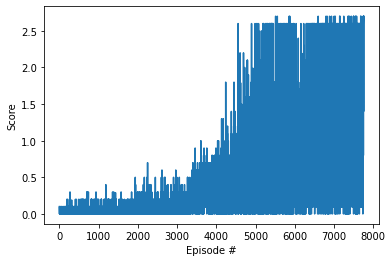

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
env.close()